In [13]:
import numpy as np
import matplotlib.pyplot as plt
import mdp_tut_functions as mdp
import env_functions as ef
from rl_utils import running_mean, discount_rwds

# set seed for pseudorandom number generation -- make sure our trajectories look the same
np.random.seed(123)

%matplotlib inline

from importlib import reload

## Knight's Tour

The goal is to move a knight across a chess board (only L-shaped moves) such that it visits every position in the 8x8 board only once

### Agent
Implement a Q-learning agent (the knight) with $\epsilon$-greedy action selection policy. 

The agent selects actions from a Q-table of state-action values (initialised at zero). Most of the time it selects the greedy action (the one with highest value) but with $\epsilon$ probability it will select a random action; this encourages the agent to explore unseen trajectories.

At each step along the trajectory the agent updates the Q-table so that it can make better choices in the future based on what it has experienced from the environment.

In [14]:
class TabularAgent(object):
    def __init__(self, nstates, nactions, 
                 learning_rate=0.1, discount=0.9, epsilon=1.0):
        
        self.num_actions = nactions
        self.action_space = np.arange(self.num_actions)

        # Q-table is initalised randomly (or at zero)
        #self.q_table = np.random.uniform(low=-1, high=1, size=(nstates, nactions))
        self.q_table = np.zeros((env.nstates, env.nactions))

        # parameters for learning
        self.epsilon       = epsilon
        self.learning_rate = learning_rate
        self.discount      = discount
        
    def choose_action(self, state):
        
        # action selection for an epsilon-greedy policy 
        if np.random.random()>self.epsilon:
            # take the action which corresponds to the highest value in the q table at that row (state)
            action = np.argmax(self.q_table[state])
        else:
            action = np.random.choice(self.action_space)
        return action

In [15]:
# TD Agents
class Q_Agent(TabularAgent):
    def __init__(self, nstates,nactions, learning_rate=0.1, discount=0.95, epsilon=1.0):
        super().__init__(nstates,nactions, learning_rate=learning_rate , discount=discount, epsilon=epsilon)

    def update_q_table(self, current_state, current_action, reward, new_state):
        current_q = self.q_table[current_state, current_action]
        max_future_q = np.max(self.q_table[new_state,:])
        
        new_q = current_q + self.learning_rate * (reward + self.discount * max_future_q - current_q)
        self.q_table[current_state, current_action] = new_q
        
    def navigate(self, env, num_episodes, random_start=True, start=0):
        # set how we will decay the randomness of action selection over the course of training
        start_eps_decay = 1
        end_eps_decay = num_episodes//2
        epsilon_decay_value = self.epsilon/(end_eps_decay-start_eps_decay)

        # initialize empty list for keeping track of rewards achieved per episode
        reward_tracking = []
        trajectory_tracking = []
        max_steps = 1000

        for episode in range(num_episodes):
            env.reset()
            self.trajectory = []
            done = False
            # initalize reward counter
            total_reward=0

            # get first state and action
            # if random_start:
            #     state=np.random.choice(env.nstates)
            # else:
            #     state=start

            state = env.state   # first state is set in environment
            self.trajectory.append(state)
            

            for step in range(max_steps):
                action = self.choose_action(state)
                # take a step in the environment
                next_state, reward, done, _ = env.step(action)

                total_reward+=reward
                self.trajectory.append(next_state)

                if not done:
                    self.update_q_table(state, action, reward, next_state)
                else:
                    self.q_table[state, action] = 0
                    break
                state=next_state

            reward_tracking.append(total_reward)
            trajectory_tracking.append(self.trajectory)

            if end_eps_decay >= episode >= start_eps_decay:
                self.epsilon -= epsilon_decay_value

        return reward_tracking, trajectory_tracking

### Environment

The environment is a chessboard with 8x8 states and 8 possible actions in each state (except along the boundaries). The transition probabilities are defined in a tensor `P(action,current_state,next_state)`.

The rewards are set up as follows:
- +1 for every step taken (to encourage the longest possible trajectory, which is 63 steps)
- -63 when revisiting a state (which is also the terminal state of the episode)

In [26]:
class ChessBoard(object):
    def __init__(self, rows=8, cols=8, **kwargs):
        '''
        :param rows (int): specifying width (x dim) of grid
        :param cols (int): specifying height (y dim) of grid
        '''
        self.shape = (rows, cols)
        self.c = cols
        self.r = rows

        self.nstates = self.c*self.r

        # Actions
        self.action_list  = kwargs.get('actionlist', ['UL', 'UR', 'RU', 'RD', 'DR', 'DL', 'LD', 'LU'])
        self.action_dict  = kwargs.get('actiondict', {x: ind for ind, x in enumerate([x for x in self.action_list])})
        self.nactions = len(self.action_list)
        self.buildTransitionMatrix()

        self.rewards = np.ones((self.nstates, self.nactions))

        self.random_start = kwargs.get('random_start',True)
    

    def buildTransitionMatrix(self):
        # initialise
        self.P = np.zeros((self.nactions, self.nstates, self.nstates))

        # Central actions
        for i in range(0,self.nstates):
            for j in range(self.nactions): # iterate over actions
                if j == 0: 
                    next_state = i-2*self.c-1
                elif j == 1:
                    next_state = i-2*self.c+1
                elif j == 2:
                    next_state = i-self.c+2
                elif j == 3:
                    next_state = i+self.c+2
                elif j == 4:
                    next_state = i+2*self.c+1
                elif j == 5:
                    next_state = i+2*self.c-1
                elif j == 6:
                    next_state = i+self.c-2
                elif j == 7:
                    next_state = i-self.c-2
                if next_state <0 or next_state>=self.nstates:  # boundary conditions to keep actions within chessboard - WRONG (it produces a torus chessboard lol)
                    next_state = i
                self.P[j,i,next_state] = 1

    def reset(self):
        if self.random_start:
            self.state = np.random.choice(np.arange(self.nstates))
        else:
            self.state = 0
            
        self.done = False
        self.trajectory = [] # to save visited states and define terminal point
        
        return


    def step(self, action):

        # check if move is valid, and then move
        # x = self.get_actions()
        if not self.action_list[action]:
            raise Exception('Agent has tried an invalid action!')
            # pass
        else:
            transition_probs = self.P[action, self.state,:]
            self.state = np.nonzero(transition_probs)[0][0]  # update to new state

        if self.state in self.trajectory: 
            self.done = True
            reward = -60
        else:
            # reward = self.rewards[self.state, action]
            reward = 1

        self.trajectory.append(self.state) 

        is_terminal = self.done

        return self.state, reward, is_terminal, {}




In [27]:
# action list
s = ['UL', 'UR', 'RU', 'RD', 'DR', 'DL', 'LD', 'LU']
{x: ind for ind,x in enumerate([x for x in s])}

{'UL': 0, 'UR': 1, 'RU': 2, 'RD': 3, 'DR': 4, 'DL': 5, 'LD': 6, 'LU': 7}

In [28]:
# Initialise environment and agent
env = ChessBoard()
q_knight = Q_Agent(env.nstates, env.nactions)

In [24]:
# Implement learning
q_rewards, q_traj = q_knight.navigate(env, num_episodes=4000)

Text(0.5, 1.0, 'Target reward: 0')

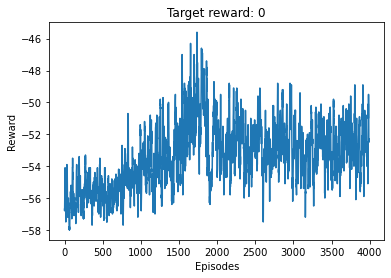

In [25]:
# Plot the learning over episodes
plt.plot(running_mean(q_rewards, N=10))
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Target reward: 0')

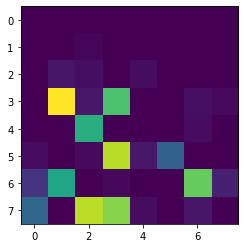

In [309]:
# plt.imshow(q_knight.q_table[:,0].reshape(env.r,env.c))